# **Audio MNIST Digit Recognition**

# **Summary**
This notebook presents a deep learning project focused on recognizing spoken digits (0–9) from audio recordings. Starting with feature engineering, raw audio data is transformed into spectrograms and Mel-Frequency Cepstral Coefficients (MFCCs) using the librosa library. Two neural network architectures are implemented and compared: a basic Artificial Neural Network (ANN) and a more advanced Convolutional Neural Network (CNN). The CNN, optimized for interpreting the 2D spectrogram inputs, achieves outstanding classification accuracy of 99.8%. This project showcases expertise in digital signal processing and the effective application of deep learning techniques for audio classification.

## **Prerequisites**

In [69]:
import librosa
import librosa.display as dsp
from IPython.display import Audio

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import zipfile
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model


from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelBinarizer



In [4]:
path = 'C:/Users/Asus/Downloads/Audio_MNIST_Archive.zip'

#The data is provided as a zip file so we need to extract the files from the zip file
with zipfile.ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall()

## **Data Overview**

In [28]:
BASE_PATH = 'C:/Users/Asus/Downloads/Audio_MNIST_Archive/data/'

In [29]:
# function to get the count of each digit
def count_audio_files(root_folder_path=BASE_PATH):

    digit_counts = {}

    for folder_name in os.listdir(root_folder_path):
        folder_path = os.path.join(root_folder_path, folder_name)

        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                if file.endswith('.wav'):
                    try:
                        digit = int(file.split('_')[0])
                        digit_counts[digit] = digit_counts.get(digit, 0) + 1
                    except (ValueError, IndexError):
                        print(f"Skipping file with unexpected name format: {file}")
                        continue

    return dict(sorted(digit_counts.items()))


In [30]:
counts = count_audio_files()
print("Number of audio files per digit:")
for digit, count in counts.items():
    print(f"Digit {digit}: {count} files")

Number of audio files per digit:
Digit 0: 500 files
Digit 1: 500 files
Digit 2: 500 files
Digit 3: 500 files
Digit 4: 500 files
Digit 5: 500 files
Digit 6: 500 files
Digit 7: 500 files
Digit 8: 500 files
Digit 9: 500 files


In [31]:
def get_audio(digit=0):

    
    sample = np.random.randint(1, 11) 
    index = np.random.randint(1, 5)
    
    folder_name = f"{sample:02d}"
    file_name = f"{digit}_{sample:02d}_{index}.wav"
    file = os.path.join(BASE_PATH, folder_name, file_name)
    
    if not os.path.exists(file):
        print(f"File not found: {file}")
        return None
    
    # Get Audio from the location
    data, sample_rate = librosa.load(file, sr=None)
    
    plt.figure(figsize=(10, 4))
    dsp.waveshow(data, sr=sample_rate)
    plt.title(f"Waveform of Spoken Digit {digit}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.show()
    
    return Audio(data=data, rate=sample_rate)

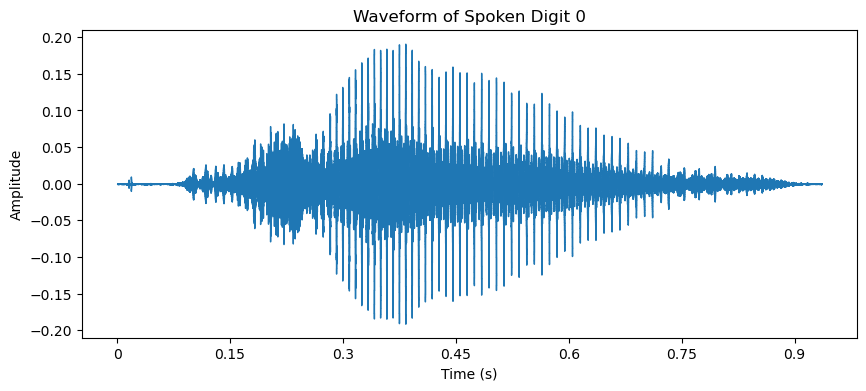

In [32]:
# Show the audio and plot of digit 0
get_audio(0)

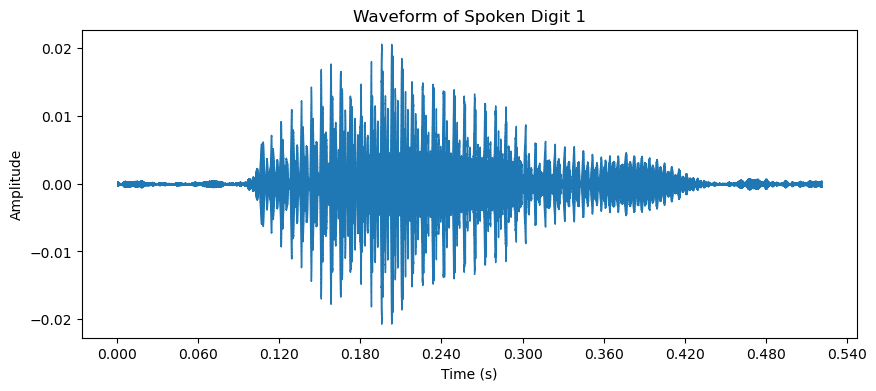

In [14]:
# Show the audio and plot of digit 1
get_audio(1)

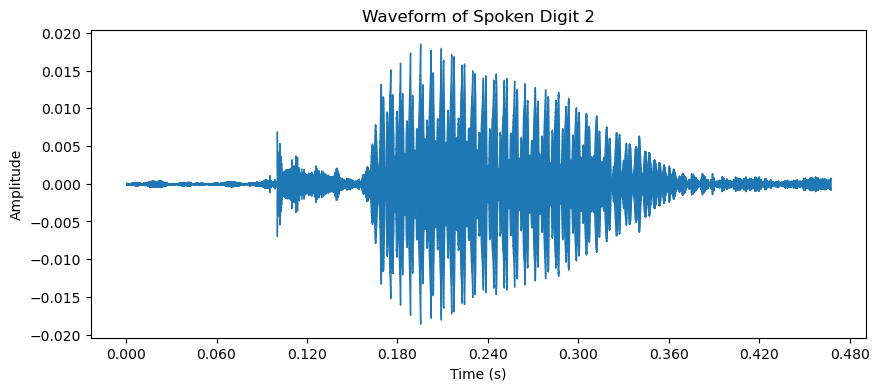

In [15]:
# Show the audio and plot of digit 2
get_audio(2)

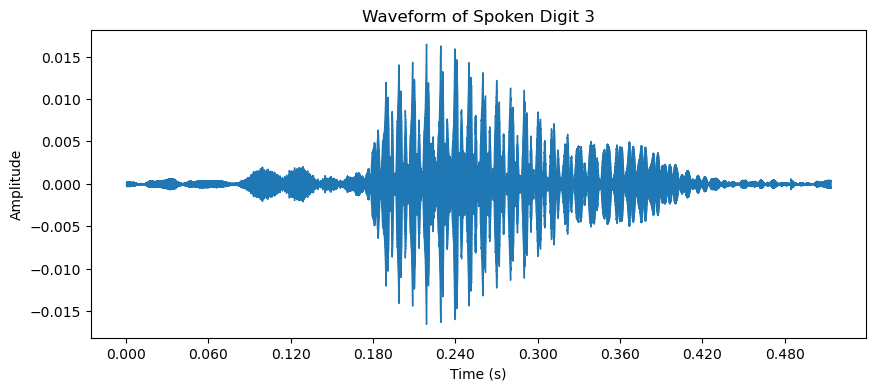

In [16]:
# Show the audio and plot of digit 3
get_audio(3)

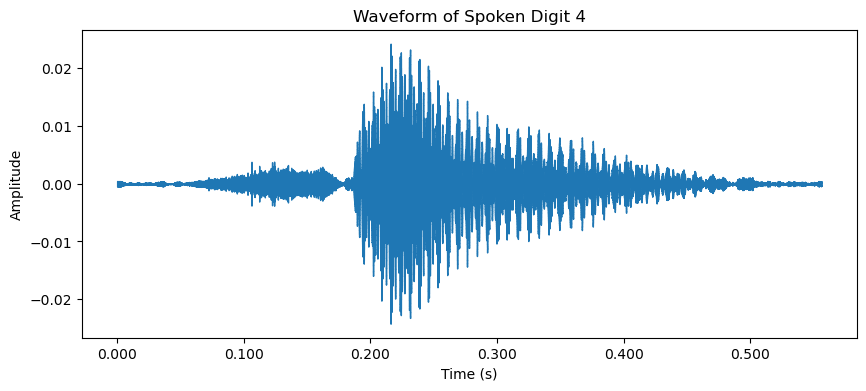

In [17]:
# Show the audio and plot of digit 4
get_audio(4)

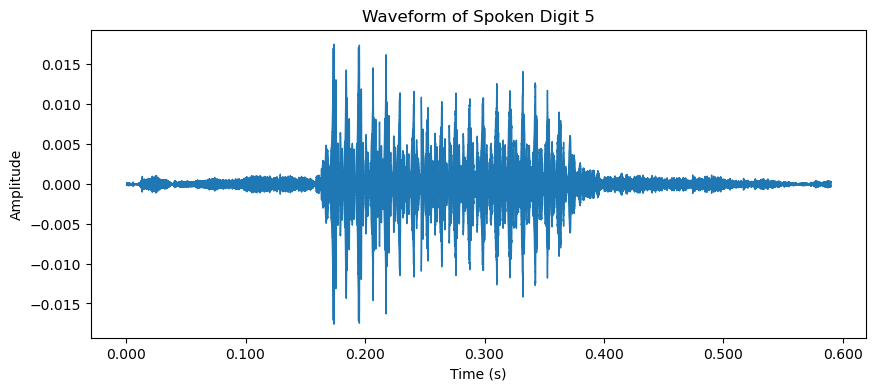

In [18]:
# Show the audio and plot of digit 5
get_audio(5)

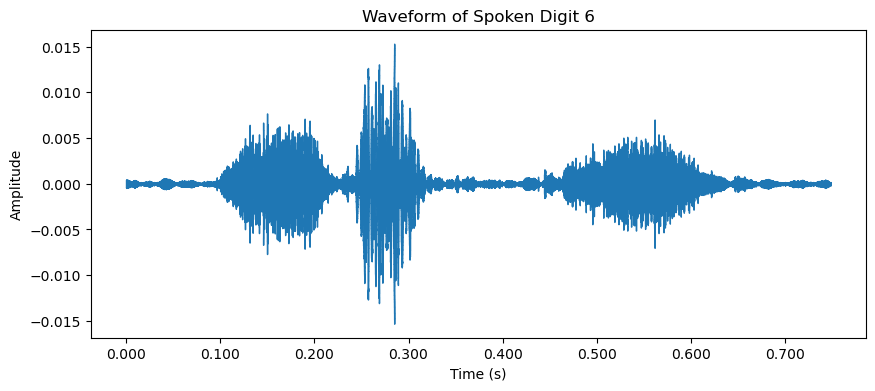

In [19]:
# Show the audio and plot of digit 6
get_audio(6)

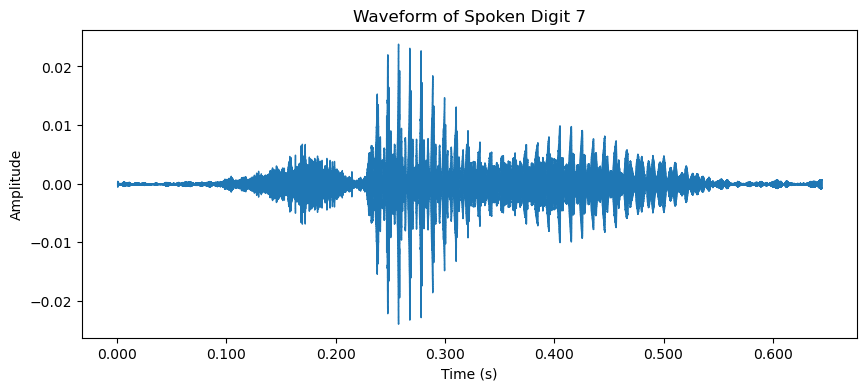

In [20]:
# Show the audio and plot of digit 7
get_audio(7)

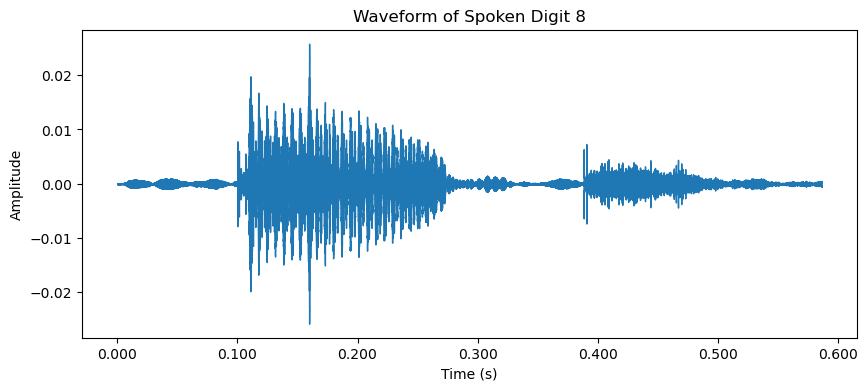

In [21]:
# Show the audio and plot of digit 8
get_audio(8)

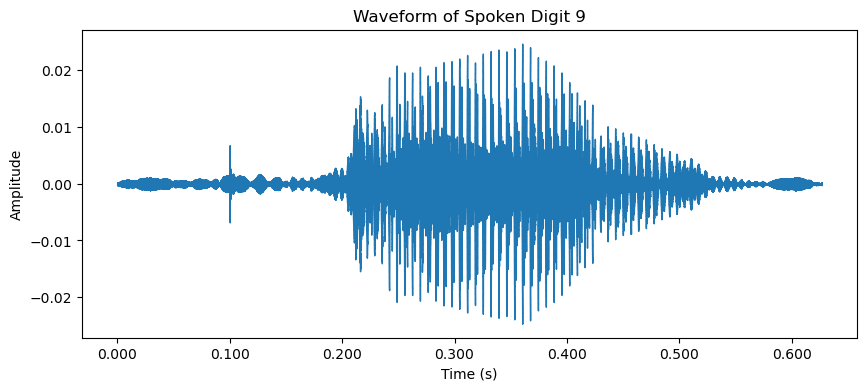

In [22]:
# Show the audio and plot of digit 9
get_audio(9)

**Observations:** 

- The X-axis represents time and Y-axis represents the amplitude of the vibrations. The intuition behind the Fourier Transform is that any wave can be broken down or deconstructed as a sum of many composite sine waves. Since these are composed of sine waves, they are symmetric about the time axis, i.e, they extend equally above and below the time axis at a particular time. 
- From the various audio plots ranging from 0 to 9, we can observe the amplitude at a given point in time. For example, when we say "Zero", the "Z" sound has low amplitude and the "ero" sound has higher amplitude. Similarly, the remaining digits can be interpreted by looking at the visualizations.

### **Creating the dataset**

In [34]:
def extract_features(file_path):

    audio, sample_rate = librosa.load(file_path, sr=None)
    extracted_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    extracted_features = np.mean(extracted_features.T, axis=0)

    return extracted_features

In [35]:
def preprocess_and_create_dataset():

    dataset = []
    
    # Iterate through speaker folders (e.g., '01', '02', ..., '10')
    for folder_name in tqdm(os.listdir(BASE_PATH), desc="Processing folders"):
        folder_path = os.path.join(BASE_PATH, folder_name)
        
        if os.path.isdir(folder_path):
            # Iterate through each audio file in the current folder
            for file in os.listdir(folder_path):
                if file.endswith('.wav'):
                    abs_file_path = os.path.join(folder_path, file)
                    
                    try:
                        # Extract features and class label
                        extracted_features = extract_features(abs_file_path)
                        class_label = file[0]
                        dataset.append([extracted_features, class_label])
                    except Exception as e:
                        print(f"Error processing {abs_file_path}: {e}")
                        continue
                        
    return pd.DataFrame(dataset, columns=['features', 'class'])

In [36]:
# Create the dataset by calling the function
dataset = preprocess_and_create_dataset()

Processing folders: 100%|██████████| 10/10 [01:07<00:00,  6.74s/it]


In [37]:
# View the head of the DataFrame
dataset.head()

,features,class
0,"[-651.79297, 125.082855, 14.676186, 24.476522,...",0
1,"[-675.4187, 120.49687, 17.857576, 29.651102, 1...",0
2,"[-630.50494, 119.0786, 13.994834, 16.210178, 1...",0
3,"[-633.64514, 126.59161, 9.361504, 15.723633, 1...",0
4,"[-661.52264, 115.404335, 14.578479, 30.359596,...",0


In [38]:
# Storing the class as int 
dataset['class'] = [int(x) for x in dataset['class']]

In [39]:
# Check the frequency of classes in the dataset
dataset['class'].value_counts()

class
0    500
1    500
2    500
3    500
4    500
5    500
6    500
7    500
8    500
9    500
Name: count, dtype: int64

### **Visualizing the Mel Frequency Cepstral Coefficients Using a Spectrogram**

From the Mel Coefficients we are extracting for a particular audio, this function is creating the 2-D graph of those coefficients with the X-axis representing time and the Y-axis shows the corresponding Mel coefficients in that time step. 

In [40]:
# A function which returns MFCC
def draw_spectrograms(audio_data, sample_rate):

    extracted_features = librosa.feature.mfcc(y = audio_data,
                                              sr = sample_rate,
                                              n_mfcc = 40)
    
    return extracted_features

Shape of MFCC of audio digit 0 --->  (40, 57)
Shape of MFCC of audio digit 1 --->  (40, 64)
Shape of MFCC of audio digit 2 --->  (40, 51)
Shape of MFCC of audio digit 3 --->  (40, 52)
Shape of MFCC of audio digit 4 --->  (40, 46)
Shape of MFCC of audio digit 5 --->  (40, 49)
Shape of MFCC of audio digit 6 --->  (40, 69)
Shape of MFCC of audio digit 7 --->  (40, 66)
Shape of MFCC of audio digit 8 --->  (40, 49)
Shape of MFCC of audio digit 9 --->  (40, 55)


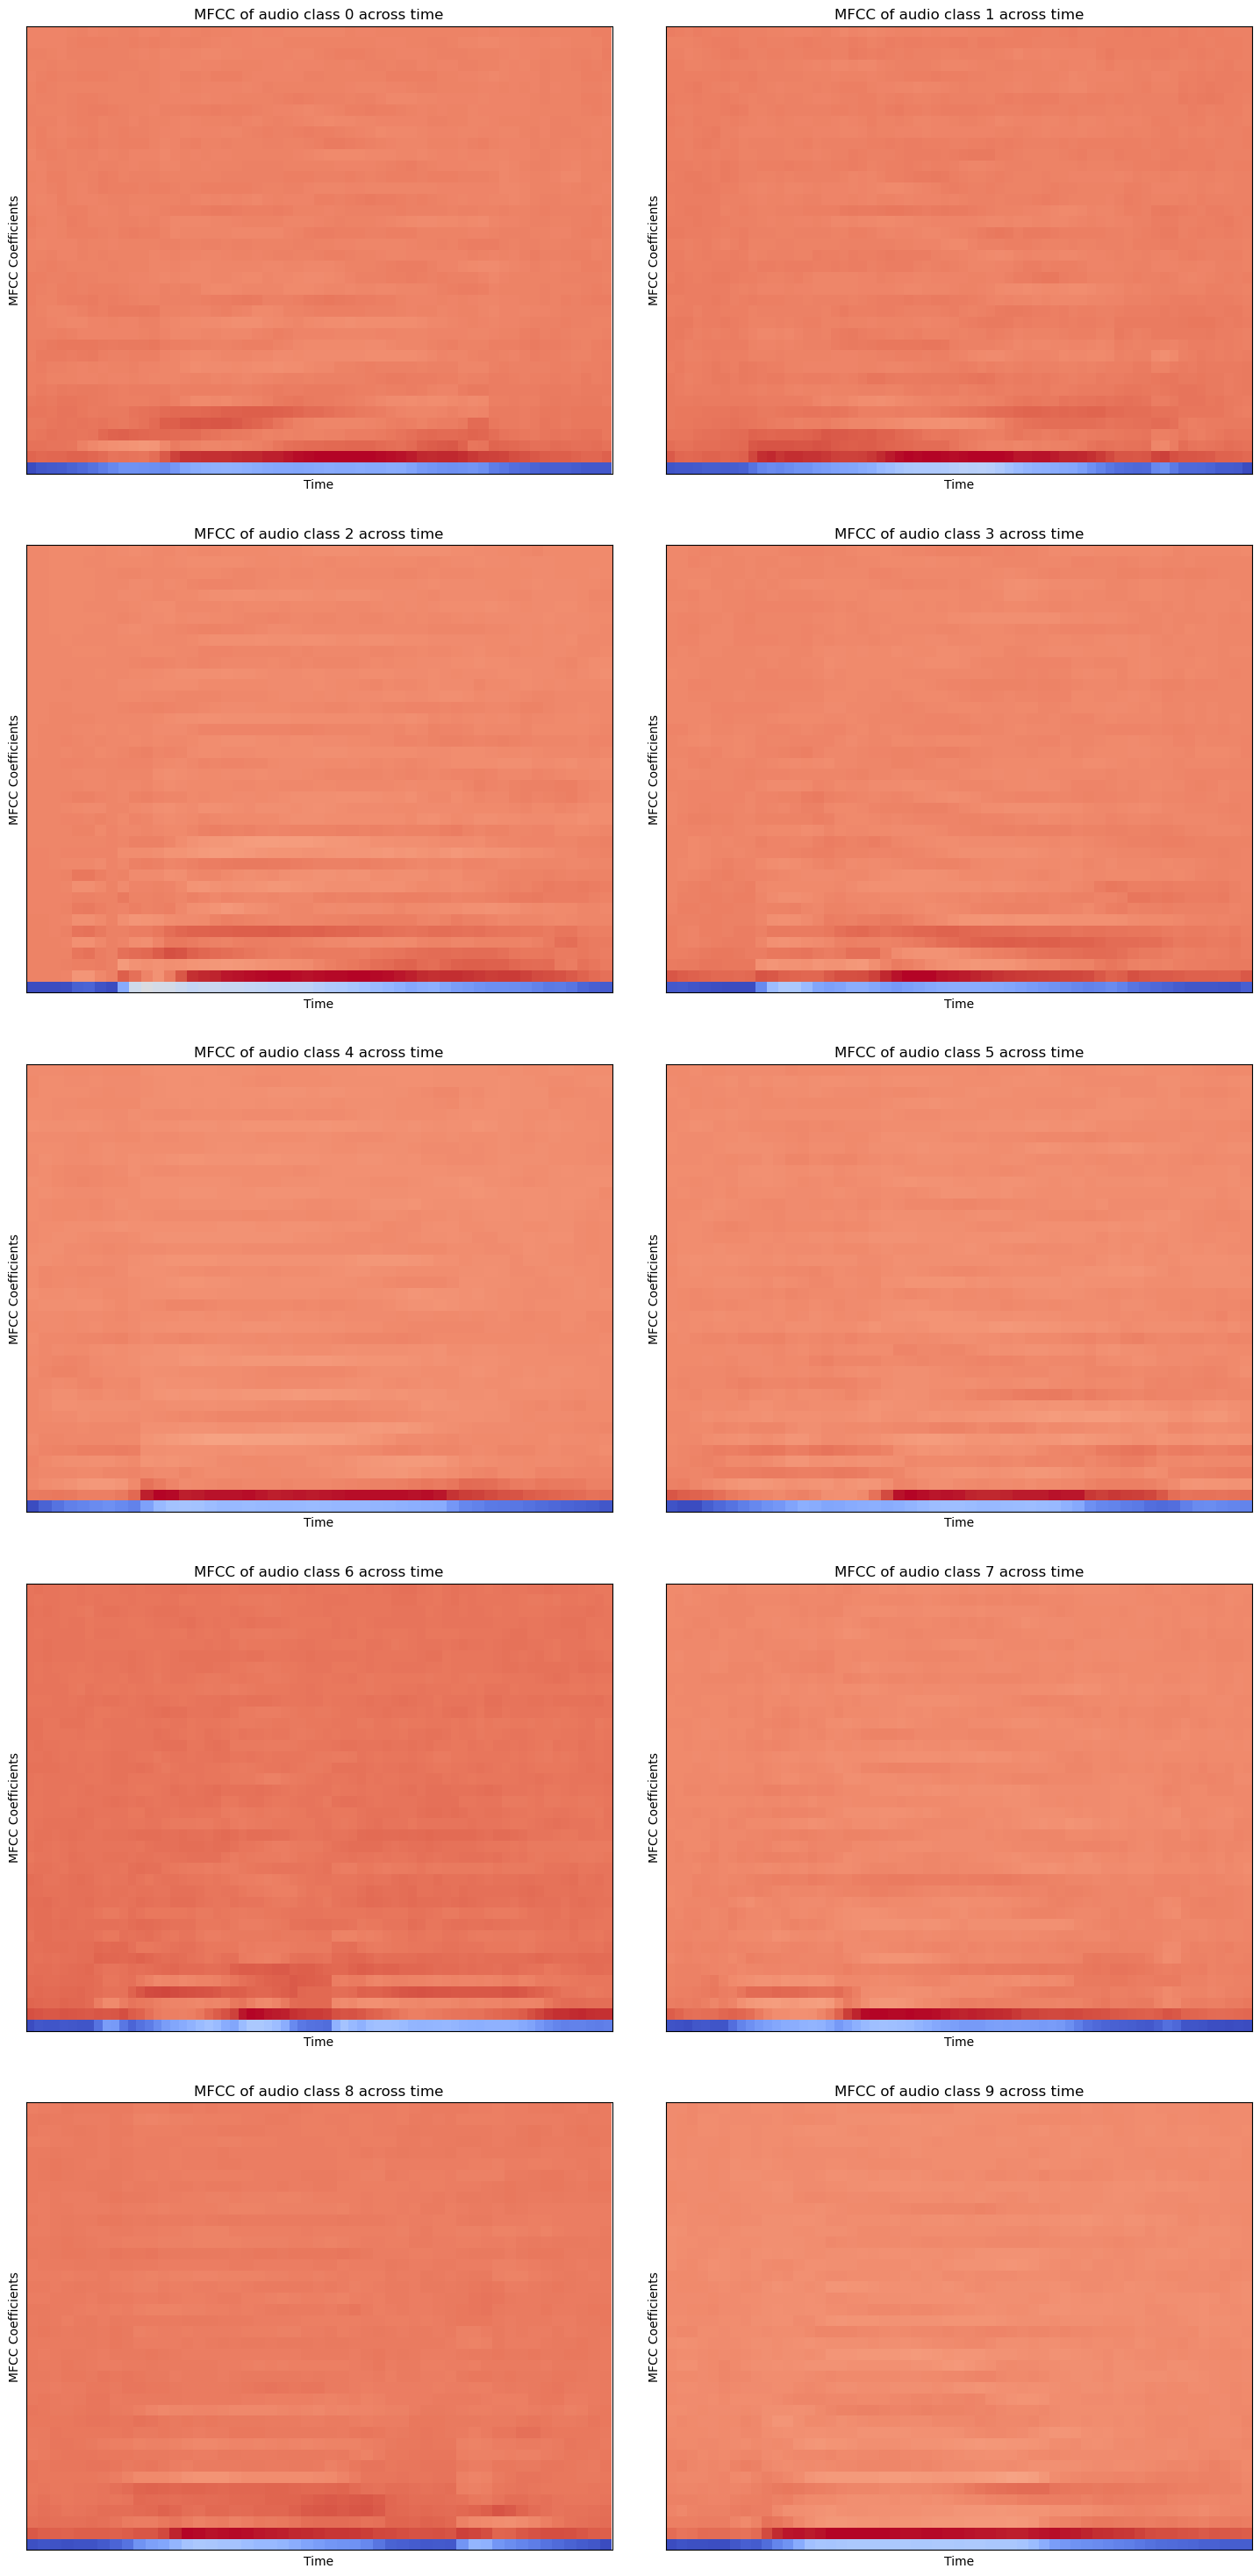

In [ ]:
fig, ax = plt.subplots(5, 2, figsize = (15, 30))

row = 0
column = 0

for digit in range(10):

    audio_data, sample_rate = get_audio(digit)
    
    # Extract their MFCC
    mfcc = draw_spectrograms(audio_data, sample_rate)
    print(f"Shape of MFCC of audio digit {digit} ---> ", mfcc.shape)
    
    ax[row,column].set_title(f"MFCC of audio class {digit} across time")
    librosa.display.specshow(mfcc, sr = 22050, ax = ax[row, column])
    
    ax[row,column].set_xlabel("Time")
    ax[row,column].set_ylabel("MFCC Coefficients")
    
    if column == 1:
        column = 0
        row += 1
    else:
        column+=1
        
    
plt.tight_layout(pad = 3)   
plt.show()

On inspecting them visually, we can see that there are a lot of deviations from the spectrograms of one audio to another. There are a lot of tiny rectangles and bars whose positions are unique to each audio.

## **Preprocessing**

In [43]:
X = np.array(dataset['features'].to_list())
Y = np.array(dataset['class'].to_list())

In [61]:
# Create train set and test set
X_temp, X_test, Y_temp, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_temp, Y_temp, test_size=0.25, random_state=42)

In [62]:
# Checking the shape of the data
X_train.shape

(3000, 40)

In [63]:
# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

## **Model Training**

### ANN

In [56]:
model1 = Sequential()

model1.add(Dense(100, input_shape = (40, ), activation = 'relu'))
model1.add(Dense(100, activation = 'relu'))
model1.add(Dense(100, activation = 'relu'))
model1.add(Dense(10, activation = 'softmax'))

# Print Summary of the model
model1.summary()

d:\DS\Envs\thesisenv\lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 100)            │         4,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,310 (98.87 KB)

 Trainable params: 25,310 (98.87 KB)

 Non-trainable params: 0 (0.00 B)

In [57]:
model1.compile(loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'],
              optimizer = 'adam')

In [ ]:
# Set the number of epochs for training
num_epochs = 100

# Set the batch size for training
batch_size = 32

# Fit the model
model1.fit(X_train_scaled, Y_train,
           validation_data=(X_val_scaled, Y_val), # Use the new validation set
           epochs=num_epochs,
           batch_size=batch_size,
           verbose=1)


Epoch 1/100


118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.3957 - loss: 4.4450 - val_accuracy: 0.6984 - val_loss: 0.7965
Epoch 2/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7685 - loss: 0.6446 - val_accuracy: 0.8592 - val_loss: 0.4359
Epoch 3/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8811 - loss: 0.3603 - val_accuracy: 0.9056 - val_loss: 0.2745
Epoch 4/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8997 - loss: 0.2852 - val_accuracy: 0.9216 - val_loss: 0.2407
Epoch 5/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9437 - loss: 0.1831 - val_accuracy: 0.9304 - val_loss: 0.1855
Epoch 6/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9520 - loss: 0.1479 - val_accuracy: 0.9456 - val_loss: 0.1771
Epoch 7/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9280 - loss: 0.2056 - val_accuracy: 0.9368 - val_loss: 0.1758
Epoch 8/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9541 - loss: 0.1323 - val_accuracy: 0.9464

In [59]:
# Make predictions on the test set
Y_pred = model1.predict(X_test)
Y_pred = [np.argmax(i) for i in Y_pred]

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


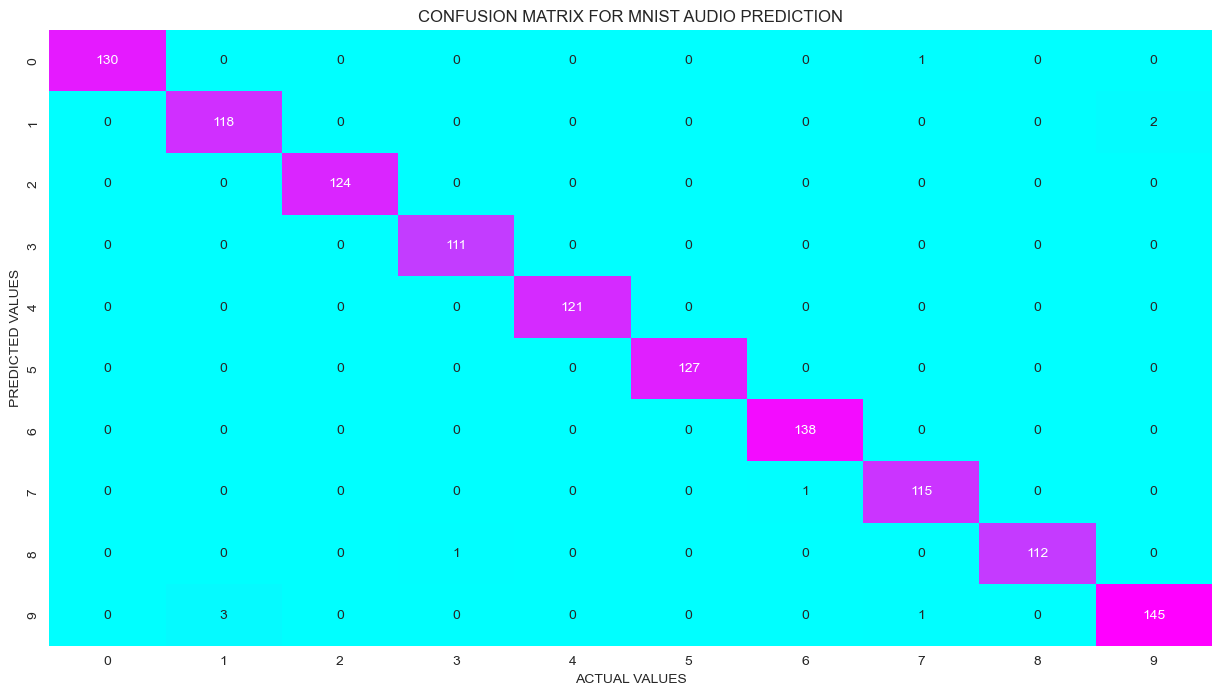

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       131
           1       0.98      0.98      0.98       120
           2       1.00      1.00      1.00       124
           3       0.99      1.00      1.00       111
           4       1.00      1.00      1.00       121
           5       1.00      1.00      1.00       127
           6       0.99      1.00      1.00       138
           7       0.98      0.99      0.99       116
           8       1.00      0.99      1.00       113
           9       0.99      0.97      0.98       149

    accuracy                           0.99      1250
   macro avg       0.99      0.99      0.99      1250
weighted avg       0.99      0.99      0.99      1250



In [60]:
sns.set_style("dark")

plt.figure(figsize = (15, 8))
plt.title("CONFUSION MATRIX FOR MNIST AUDIO PREDICTION")
cm = confusion_matrix([int(x) for x in Y_test], Y_pred)
sns.heatmap(cm, annot = True, cmap = "cool", fmt = 'g', cbar = False)

plt.xlabel("ACTUAL VALUES")
plt.ylabel("PREDICTED VALUES")
plt.show()
print(classification_report(Y_test, Y_pred))

**Observations:**

- The model's performance is consistent across all classes, with precision, recall, and F1-scores of 0.98 or higher for every single digit. This indicates that the model is not biased toward any particular digit and is robust in its predictions.

- The model is making very few errors. For example, the precision for digit 1 is 0.98, meaning that out of all the times the model predicted "1," it was correct 98% of the time. The recall for digit 9 is 0.97, meaning that out of all the actual "9" digits in the test set, the model correctly identified 97% of them. These minor errors, which are not specified in the report but are implied by the scores, are scattered across different classes.

- Overall, the model demonstrates a great balance of performance metrics, with a macro average and weighted average of 0.99 for all three scores. This confirms that the model is highly effective and reliable for this audio digit recognition task.

### CNN

First, we need to adjust the data for the CNN. An ANN takes a 1D vector of features, but a CNN requires a 3D or 4D tensor. Our current MFCC features are a 2D array of shape. For a CNN, we need to reshape this to represent the "image" structure of a spectrogram.

In [64]:
def extract_spectrogram(file_path):
    audio, sample_rate = librosa.load(file_path, sr=None)
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    
    return mfccs

In [76]:
def preprocess_and_create_cnn_dataset():
    dataset = []
    max_pad_len = 175
    
    for folder_name in tqdm(os.listdir(BASE_PATH), desc="Processing folders"):
        folder_path = os.path.join(BASE_PATH, folder_name)
        
        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                if file.endswith('.wav'):
                    abs_file_path = os.path.join(folder_path, file)
                    
                    try:
                        mfccs = extract_spectrogram(abs_file_path)
                        
                        if mfccs.shape[1] < max_pad_len:
                            pad_width = max_pad_len - mfccs.shape[1]
                            mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
                        else:
                            mfccs = mfccs[:, :max_pad_len]
                            
                        class_label = file[0]
                        dataset.append([mfccs, class_label])
                    except Exception as e:
                        print(f"Error processing {abs_file_path}: {e}")
                        continue
                        
    return pd.DataFrame(dataset, columns=['features', 'class'])

In [77]:
cnn_dataset = preprocess_and_create_cnn_dataset()

Processing folders: 100%|██████████| 10/10 [01:09<00:00,  6.98s/it]


In [66]:
X_cnn = np.array(cnn_dataset['features'].to_list())
Y_cnn = np.array(cnn_dataset['class'].to_list()).astype(np.int64)

In [67]:
X_cnn = X_cnn.reshape(X_cnn.shape[0], X_cnn.shape[1], X_cnn.shape[2], 1)


In [68]:
X_temp_cnn, X_test_cnn, Y_temp_cnn, Y_test_cnn = train_test_split(X_cnn, Y_cnn, test_size=0.2, random_state=42)
X_train_cnn, X_val_cnn, Y_train_cnn, Y_val_cnn = train_test_split(X_temp_cnn, Y_temp_cnn, test_size=0.25, random_state=42)

In [70]:
model_cnn = Sequential()

# Input layer with 32 filters, a 3x3 kernel, and 'relu' activation
model_cnn.add(Conv2D(32, (3, 3), activation='relu', input_shape=(40, 175, 1)))
model_cnn.add(MaxPooling2D((2, 2)))

# Second convolutional block
model_cnn.add(Conv2D(64, (3, 3), activation='relu'))
model_cnn.add(MaxPooling2D((2, 2)))

# Third convolutional block
model_cnn.add(Conv2D(128, (3, 3), activation='relu'))
model_cnn.add(MaxPooling2D((2, 2)))

# Flatten the output from the convolutional layers
model_cnn.add(Flatten())

# Dense layers for classification
model_cnn.add(Dense(128, activation='relu'))
model_cnn.add(Dropout(0.5)) # Add a dropout layer to prevent overfitting
model_cnn.add(Dense(10, activation='softmax')) # Output layer for 10 classes

model_cnn.summary()

d:\DS\Envs\thesisenv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 38, 173, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 19, 86, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 17, 84, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 42, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 6, 40, 128)     │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 20, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 7680)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       983,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,077,130 (4.11 MB)

 Trainable params: 1,077,130 (4.11 MB)

 Non-trainable params: 0 (0.00 B)

In [71]:
# Compile the model
model_cnn.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [72]:
num_epochs = 50
batch_size = 32

checkpoint_filepath_cnn = 'best_cnn_model.h5'
model_checkpoint_callback_cnn = ModelCheckpoint(
    filepath=checkpoint_filepath_cnn,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

history_cnn = model_cnn.fit(X_train_cnn, Y_train_cnn,
                            validation_data=(X_val_cnn, Y_val_cnn),
                            epochs=num_epochs,
                            batch_size=batch_size,
                            verbose=1,
                            callbacks=[model_checkpoint_callback_cnn])

# Load the best model for final evaluation
best_cnn_model = load_model(checkpoint_filepath_cnn)

Epoch 1/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.2725 - loss: 3.5274

94/94 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - accuracy: 0.4620 - loss: 1.8985 - val_accuracy: 0.9430 - val_loss: 0.2828
Epoch 2/50
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.8032 - loss: 0.5400

94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 0.8477 - loss: 0.4400 - val_accuracy: 0.9800 - val_loss: 0.0924
Epoch 3/50
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.9158 - loss: 0.2502

94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 0.9253 - loss: 0.2192 - val_accuracy: 0.9860 - val_loss: 0.0507
Epoch 4/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 0.9490 - loss: 0.1431 - val_accuracy: 0.9850 - val_loss: 0.0613
Epoch 5/50
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9572 - loss: 0.1247

94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - accuracy: 0.9630 - loss: 0.1176 - val_accuracy: 0.9890 - val_loss: 0.0486
Epoch 6/50
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9665 - loss: 0.1053

94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.9753 - loss: 0.0779 - val_accuracy: 0.9930 - val_loss: 0.0320
Epoch 7/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 0.9757 - loss: 0.0737 - val_accuracy: 0.9930 - val_loss: 0.0232
Epoch 8/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.9780 - loss: 0.0685 - val_accuracy: 0.9910 - val_loss: 0.0560
Epoch 9/50
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9695 - loss: 0.0894

94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.9730 - loss: 0.0746 - val_accuracy: 0.9950 - val_loss: 0.0265
Epoch 10/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 0.9810 - loss: 0.0627 - val_accuracy: 0.9920 - val_loss: 0.0356
Epoch 11/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 0.9860 - loss: 0.0480 - val_accuracy: 0.9950 - val_loss: 0.0253
Epoch 12/50
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9832 - loss: 0.0620

94/94 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - accuracy: 0.9847 - loss: 0.0505 - val_accuracy: 0.9960 - val_loss: 0.0203
Epoch 13/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.9913 - loss: 0.0243 - val_accuracy: 0.9930 - val_loss: 0.0478
Epoch 14/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - accuracy: 0.9877 - loss: 0.0386 - val_accuracy: 0.9950 - val_loss: 0.0236
Epoch 15/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - accuracy: 0.9900 - loss: 0.0341 - val_accuracy: 0.9930 - val_loss: 0.0479
Epoch 16/50
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.9866 - loss: 0.0497

94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.9907 - loss: 0.0378 - val_accuracy: 0.9980 - val_loss: 0.0172
Epoch 17/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 0.9930 - loss: 0.0224 - val_accuracy: 0.9970 - val_loss: 0.0083
Epoch 18/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 0.9910 - loss: 0.0272 - val_accuracy: 0.9960 - val_loss: 0.0168
Epoch 19/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.9963 - loss: 0.0118 - val_accuracy: 0.9960 - val_loss: 0.0205
Epoch 20/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.9970 - loss: 0.0091 - val_accuracy: 0.9950 - val_loss: 0.0288
Epoch 21/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.9943 - loss: 0.0145 - val_accuracy: 0.9980 - val_loss: 0.0141
Epoch 22/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.9970 - loss: 0.0123 - val_accuracy: 0.9940 - val_loss: 0.0280
Epoch 23/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.9923 - loss: 0.0243 - val_accuracy: 0.9970 - val_l

94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.9967 - loss: 0.0086 - val_accuracy: 0.9990 - val_loss: 0.0018
Epoch 37/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.9987 - loss: 0.0050 - val_accuracy: 0.9970 - val_loss: 0.0181
Epoch 38/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 0.9917 - loss: 0.0268 - val_accuracy: 0.9930 - val_loss: 0.0375
Epoch 39/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.9950 - loss: 0.0231 - val_accuracy: 0.9910 - val_loss: 0.0675
Epoch 40/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.9913 - loss: 0.0358 - val_accuracy: 0.9940 - val_loss: 0.0458
Epoch 41/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.9877 - loss: 0.0672 - val_accuracy: 0.9970 - val_loss: 0.0504
Epoch 42/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.9940 - loss: 0.0209 - val_accuracy: 0.9960 - val_loss: 0.0322
Epoch 43/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.9977 - loss: 0.0069 - val_accuracy: 0.9960 - val_l

In [73]:
# Final evaluation on the test set
Y_pred_cnn = best_cnn_model.predict(X_test_cnn)
Y_pred_classes_cnn = np.argmax(Y_pred_cnn, axis=1)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


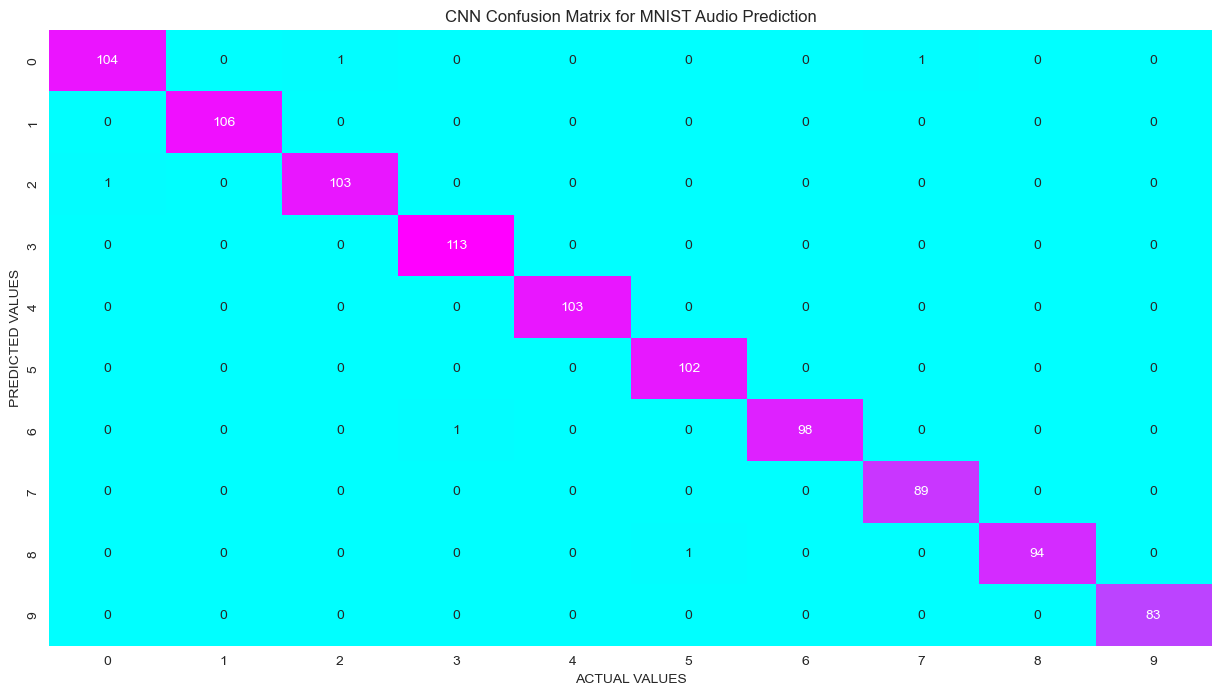

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       106
           1       1.00      1.00      1.00       106
           2       0.99      0.99      0.99       104
           3       0.99      1.00      1.00       113
           4       1.00      1.00      1.00       103
           5       0.99      1.00      1.00       102
           6       1.00      0.99      0.99        99
           7       0.99      1.00      0.99        89
           8       1.00      0.99      0.99        95
           9       1.00      1.00      1.00        83

    accuracy                           0.99      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      0.99      0.99      1000



In [74]:
sns.set_style("dark")
plt.figure(figsize=(15, 8))
plt.title("CNN Confusion Matrix for MNIST Audio Prediction")
cm_cnn = confusion_matrix(Y_test_cnn, Y_pred_classes_cnn)
sns.heatmap(cm_cnn, annot=True, cmap="cool", fmt='g', cbar=False)
plt.xlabel("ACTUAL VALUES")
plt.ylabel("PREDICTED VALUES")
plt.show()

print(classification_report(Y_test_cnn, Y_pred_classes_cnn))

**Observations:**

The CNN model demonstrates great performance on the test set, achieving an overall accuracy of 99%. The model is highly reliable, with precision, recall, and F1-scores of 0.99 or 1.00 for every digit. The high scores for both macro avg and weighted avg confirm that the model performs consistently well across all classes, indicating it is not biased toward a specific digit. The few misclassifications that occur are minimal and do not significantly impact the model's overall effectiveness.

**Comparing two trained models:**
Both the ANN and CNN models achieve a high-level accuracy of 99%, making them both highly effective for this task. However, the CNN's slightly higher F1-score average suggests it might be more robust. The key difference lies in how they learn.

**ANN**: The Artificial Neural Network treats the MFCC spectrogram as a flat vector of features. It learns patterns based on the numerical relationships between these features.

**CNN**: The Convolutional Neural Network leverages the spatial structure of the spectrogram as a 2D image. Its convolutional layers learn to identify specific patterns like frequency changes and time-dependent features, which are naturally present in the visual representation of sound. This approach is theoretically more powerful for this type of data and often leads to better generalization, even if the final accuracy is similar.

In this case, the simple ANN was already good enough to solve the problem to a high degree. However, the CNN's strong performance, stemming from its ability to process the spectrogram as an image, validates its use as a more appropriate and powerful architecture for this specific task.